  0%|          | 0/50 [00:00<?, ?it/s]

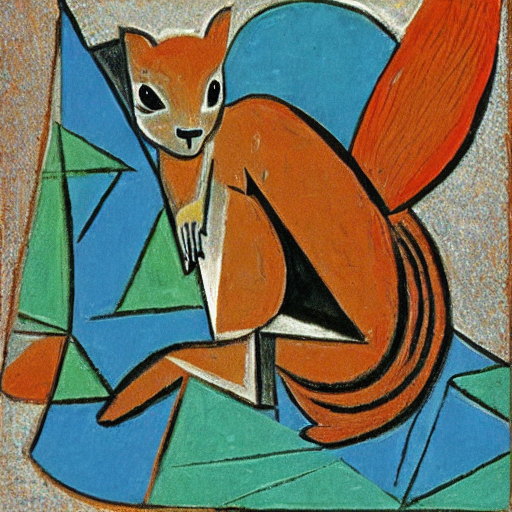

In [1]:
#第2章/快速上手
from diffusers import DiffusionPipeline
import torch

#加载预训练Diffusion模型
pipeline = DiffusionPipeline.from_pretrained('runwayml/stable-diffusion-v1-5')


def test_pipeline():
    pipeline.to('cuda' if torch.cuda.is_available() else 'cpu')

    #测试画图
    image = pipeline('An image of a squirrel in Picasso style').images[0]

    #保存图片
    image.save('save/sample.jpg')

    return image


test_pipeline()

In [2]:
#第2章/测试tokenizer
from transformers import CLIPTokenizer

checkpoint = 'CompVis/stable-diffusion-v1-4'
tokenizer = CLIPTokenizer.from_pretrained(checkpoint, subfolder='tokenizer')


#测试tokenizer
def test_tokenizer():
    text = 'the quick brown fox jumps over a lazy dog'
    out = tokenizer(text,
                    max_length=13,
                    padding='max_length',
                    truncation=True,
                    return_tensors='pt')

    for k, v in out.items():
        print(k, v)

    print(tokenizer.decode(out['input_ids'][0]))


test_tokenizer()

input_ids tensor([[49406,   518,  3712,  2866,  3240, 18911,   962,   320, 10753,  1929,
         49407, 49407, 49407]])
attention_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]])
<|startoftext|>the quick brown fox jumps over a lazy dog <|endoftext|><|endoftext|><|endoftext|>


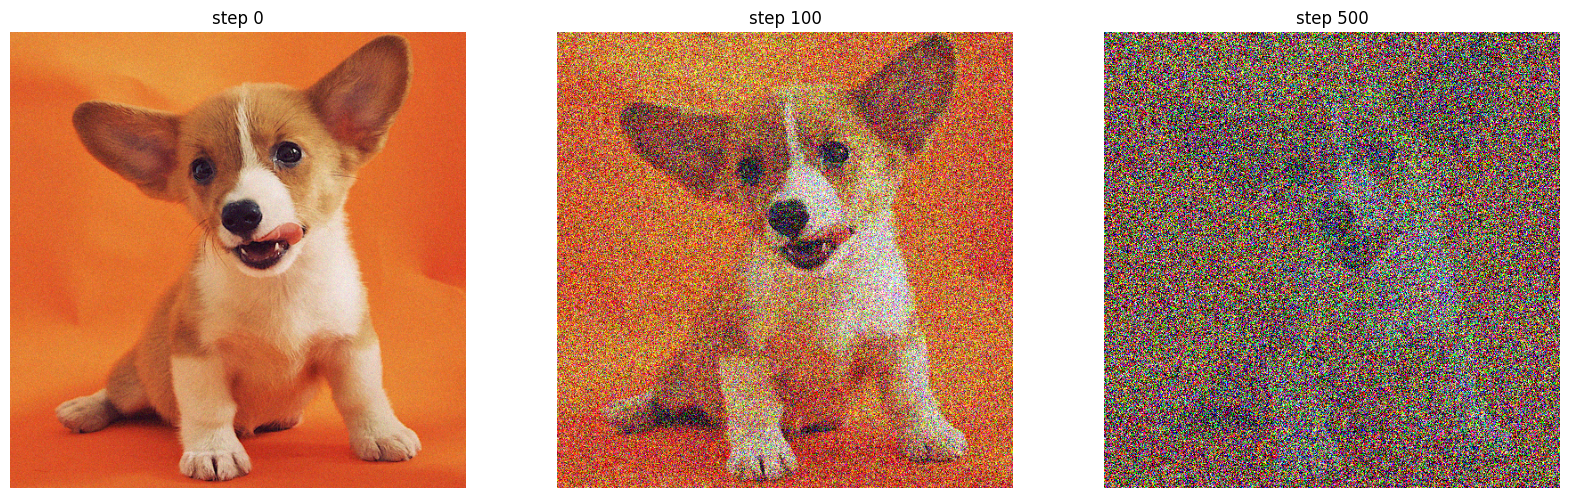

In [3]:
#第2章/测试scheduler
from diffusers import DDPMScheduler

scheduler = DDPMScheduler.from_pretrained(checkpoint, subfolder='scheduler')


#测试scheduler
def test_scheduler():
    from matplotlib import pyplot as plt
    import PIL.Image
    import numpy as np
    import torchvision

    plt.figure(figsize=(20, 10))

    #加载测试图片
    image = PIL.Image.open('测试图片.jpeg').resize((512, 512))
    image = torch.FloatTensor(np.array(image)) / 255.0

    #随机噪声
    noise = torch.randn(image.shape)

    for i, step in enumerate([0, 100, 500]):
        #添加噪声
        image_noise = scheduler.add_noise(image, noise,
                                          torch.LongTensor([step])).clip(0, 1)

        #保存图片
        torchvision.utils.save_image(image_noise.permute(2, 0, 1),
                                     'save/%d.jpg' % step)

        #显示图片
        plt.subplot(1, 3, i + 1)
        plt.imshow(image_noise)
        plt.axis('off')
        plt.title('step %d' % step)

    plt.show()


test_scheduler()

In [4]:
#第2章/测试Encoder
from transformers import CLIPTextModel

#加载3个模型
encoder = CLIPTextModel.from_pretrained(checkpoint, subfolder='text_encoder')


#测试Encoder,可以简单地理解成文字embed层
def test_encoder():
    input_ids = torch.LongTensor(
        [[49406, 320, 1746, 537, 1449, 14115, 593, 1237, 3095, 49407, 49407]])

    out_encoder = encoder(input_ids)[0]

    print(out_encoder.shape, out_encoder.dtype)


test_encoder()

torch.Size([1, 11, 768]) torch.float32


In [5]:
#第2章/测试VAE
from diffusers import AutoencoderKL

vae = AutoencoderKL.from_pretrained(checkpoint, subfolder='vae')


#测试VAE,它的计算结果是一张图征图的mena和std
def test_vae():
    pixel_values = torch.randn(1, 3, 512, 512).clip(min=-1.0, max=1.0)

    #根据数据计算出正态分布的mean和std
    out_vae = vae.encode(pixel_values).latent_dist

    #[1, 4, 64, 64], [1, 4, 64, 64]
    print(out_vae.mean.shape, out_vae.std.shape)

    #根据mean和std采样
    #等价写法:sample = out_vae.mean + out_vae.std * torch.randn(1, 4, 64, 64)
    #[1, 4, 64, 64]
    out_vae = out_vae.sample()

    #乘以系数,0.18215 = vae.config.scaling_factor
    out_vae = out_vae * 0.18215

    #[1, 4, 64, 64]
    print(out_vae.shape, out_vae.dtype)

    #特征图解码成图片
    out_vae = vae.decode(torch.randn(1, 4, 64, 64)).sample

    #[1, 3, 512, 512]
    print(out_vae.shape, out_vae.dtype)


test_vae()

torch.Size([1, 4, 64, 64]) torch.Size([1, 4, 64, 64])
torch.Size([1, 4, 64, 64]) torch.float32
torch.Size([1, 3, 512, 512]) torch.float32


In [6]:
#第2章/测试U-Net
from diffusers import UNet2DConditionModel

unet = UNet2DConditionModel.from_pretrained(checkpoint, subfolder='unet')


#测试U-Net
def test_unet():
    #虚拟Encoder和VAE的输出
    out_encoder = torch.randn(1, 77, 768)
    out_vae = torch.randn(1, 4, 64, 64)

    #随机噪声,也就是U-Net计算的目标
    noise = torch.randn_like(out_vae)

    #这个数字实际应该是随机得到的,值域0~999
    noise_step = torch.LongTensor([500])

    #往VAE输出的特征图中添加噪声
    out_vae_noise = scheduler.add_noise(out_vae, noise, noise_step)

    #U-Net的目标是把添加的噪声计算出来
    out_unet = unet(out_vae_noise, noise_step, out_encoder).sample

    print(out_unet.shape, out_unet.dtype)


test_unet()

torch.Size([1, 4, 64, 64]) torch.float32
